# SIGNS

### Data format  (# of examples, *features)

* X_train  -- (1080, 64, 64, 3)
* X_test  -- (120, 64, 64, 3)
* Y_train  -- (1080, 6)
* Y_test  -- (120,6)


### Model 
* 4 layer Convolutional network

* (1080, 64, 64, 3) --conv(5x5x3x32)--> (1080, 64,64,32) --Maxpool(2x2)-->
* --> (1080, 32,32,32) --conv(5x5x32x64)--> (1080, 32,32,64) --Maxpool(2x2)-->
* -->(1080, 16, 16, 64) --Flatten-->  (1080, 16384) --FC--> (1080, 1024) --dropout-->
* --> --FC--> (1080,6)

### Results
* Train Accuracy 98%
* Test Accuracy 85%

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow.python.framework import ops
import tensorflow as tf


### Helper functions

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

### Loading the dataset

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

### Preprocessing data

In [4]:
# Normalize X
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert Ys to onehot
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

### Model

In [5]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 10

num_classes = 6 # total classes
dropout = 0.75 # Dropout, probability to keep units

In [8]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 3 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 3, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 16*16*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([16*16*64, 1024])),
    # 1024 inputs, 6 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [9]:
# tf Graph placeholders (inputs)
X = tf.placeholder(tf.float32, (None, 64,64,3))
Y = tf.placeholder(tf.float32, (None, num_classes))
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [10]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [12]:
# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    #x = tf.reshape(x, shape=[-1, 64, 64, 3])  #???

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [13]:
# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Training

Cost after epoch 0: 295726.853516
Cost after epoch 5: 74090.143066
Cost after epoch 10: 26230.776855
Cost after epoch 15: 8795.811462
Cost after epoch 20: 4126.313507
Cost after epoch 25: 2409.645950
Cost after epoch 30: 1258.543720
Cost after epoch 35: 1228.904243
Cost after epoch 40: 999.562119
Cost after epoch 45: 653.902622
Cost after epoch 50: 453.496191
Cost after epoch 55: 351.750589
Cost after epoch 60: 215.424769
Cost after epoch 65: 246.210732
Cost after epoch 70: 198.960298
Cost after epoch 75: 289.959491
Cost after epoch 80: 286.841309
Cost after epoch 85: 83.182018
Cost after epoch 90: 103.485673
Cost after epoch 95: 146.185040


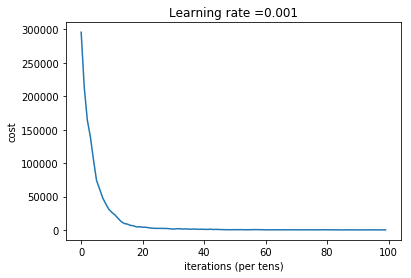

Train Accuracy: 0.975
Test Accuracy: 0.85


In [16]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        m = X_train.shape[0]
        minibatch_size = 128
        print_cost = True
        costs = []
        num_epochs = 100
        seed = 3
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([train_op, loss_op], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: dropout})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, keep_prob: dropout})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test, keep_prob: dropout})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)